In [8]:
## Imports

import math
import numpy as np
import pandas as pd
import scipy.stats

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

## Data Imports
- Original Data located in root directory

In [9]:
train = pd.read_csv('../Data/train.csv', index_col='Id')
test = pd.read_csv('../Data/test.csv', index_col='Id')

# 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'KitchenQual', 'GarageQual', 'GarageCond'
# 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',  'KitchenQual',  'GarageQual', 'GarageCond'

train_cols = ['SalePrice', 'LotFrontage', 'LotArea', 'Neighborhood', 'OverallQual', 'OverallCond', 'YearBuilt', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'WoodDeckSF', 'OpenPorchSF', '3SsnPorch', 'ScreenPorch', 'EnclosedPorch', 'GarageArea', 'YrSold', 'MoSold']
test_cols = ['LotFrontage', 'LotArea', 'Neighborhood', 'OverallQual', 'OverallCond', 'YearBuilt', '1stFlrSF', 'TotalBsmtSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'WoodDeckSF', 'OpenPorchSF', '3SsnPorch', 'ScreenPorch', 'EnclosedPorch', 'GarageArea', 'YrSold', 'MoSold']

train['YrSold']= train['YrSold'].astype(str)
test['YrSold'] = train['YrSold'].astype(str)

train['MoSold']= train['MoSold'].astype(str)
test['MoSold'] = train['MoSold'].astype(str)

train['OverallQual']= train['OverallQual'].astype(str)
test['OverallQual'] = test['OverallQual'].astype(str)

train['OverallCond']= train['OverallCond'].astype(str)
test['OverallCond'] = test['OverallCond'].astype(str)

train = train[train_cols]
test = test[test_cols]

train['TotalSF'] = train.TotalBsmtSF + train.GrLivArea
train['TotalPorchSF'] = train.OpenPorchSF + train.EnclosedPorch + train['3SsnPorch'] + train.ScreenPorch

test['TotalSF'] = test.TotalBsmtSF + test.GrLivArea
test['TotalPorchSF'] = test.OpenPorchSF + test.EnclosedPorch + \
    test['3SsnPorch'] + test.ScreenPorch

train['TotalBaths'] = train.FullBath + (.5 * train.HalfBath) + train.BsmtFullBath + (.5 * train.BsmtHalfBath)
test['TotalBaths'] = test.FullBath + (.5 * test.HalfBath) + test.BsmtFullBath + (.5 * test.BsmtHalfBath)

train['YearsOld'] = 2022 - train['YearBuilt']
test['YearsOld'] = 2022 - test['YearBuilt']

# We heed the author's advice and cut out anything over 4,000 sq ft
train.drop(train[train.GrLivArea >= 4000].index, inplace=True)

# We heed the author's advice and cut out anything over 4,000 sq ft
test.drop(test[test.GrLivArea >= 4000].index, inplace=True)

# LotFrontage is "Linear feet of street connected to property"
# Since it seems unlikely that there's no street connected
# to a lot, we'll set it equal to the median LotFrontage of that street.
train.LotFrontage = train.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

train = train.drop(columns=['TotalBsmtSF', 'GrLivArea', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', '1stFlrSF', '2ndFlrSF', 'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath', 'YearBuilt'])
test = test.drop(columns=['TotalBsmtSF', 'GrLivArea', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', '1stFlrSF', '2ndFlrSF', 'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath', 'YearBuilt'])

train.head(5)

,SalePrice,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,TotRmsAbvGrd,WoodDeckSF,GarageArea,YrSold,MoSold,TotalSF,TotalPorchSF,TotalBaths,YearsOld
Id,,,,,,,,,,,,,,,
1,208500,65.0,8450,CollgCr,7,5,8,0,548,2008,2,2566,61,3.5,19
2,181500,80.0,9600,Veenker,6,8,6,298,460,2007,5,2524,0,2.5,46
3,223500,68.0,11250,CollgCr,7,5,6,0,608,2008,9,2706,42,3.5,21
4,140000,60.0,9550,Crawfor,7,5,7,0,642,2006,2,2473,307,2.0,107
5,250000,84.0,14260,NoRidge,8,5,9,192,836,2008,12,3343,84,3.5,22


In [10]:
train.SalePrice.describe()

count      1456.000000
mean     180151.233516
std       76696.592530
min       34900.000000
25%      129900.000000
50%      163000.000000
75%      214000.000000
max      625000.000000
Name: SalePrice, dtype: float64

## Function Definition for getting feature types (categorical vs numerical)

In [11]:
def get_feature_groups():
    """ Returns a list of numerical and categorical features,
    excluding SalePrice and Id. """
    # Numerical Features
    num_features = train.select_dtypes(include=['int64','float64']).columns
    num_features = num_features.drop(['SalePrice']) # drop ID and SalePrice

    # Categorical Features
    cat_features = train.select_dtypes(include=['object']).columns
    return list(num_features), list(cat_features)

num_features, cat_features = get_feature_groups()

# Categorical features with "NA" values
missing_values = (train[cat_features] == 'NA').sum().sort_values(ascending=False)
missing_values[missing_values > 0]

Series([], dtype: int64)

In [12]:
train.OverallQual.value_counts()

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     14
2       3
1       2
Name: OverallQual, dtype: int64

## Analysis of numerical features

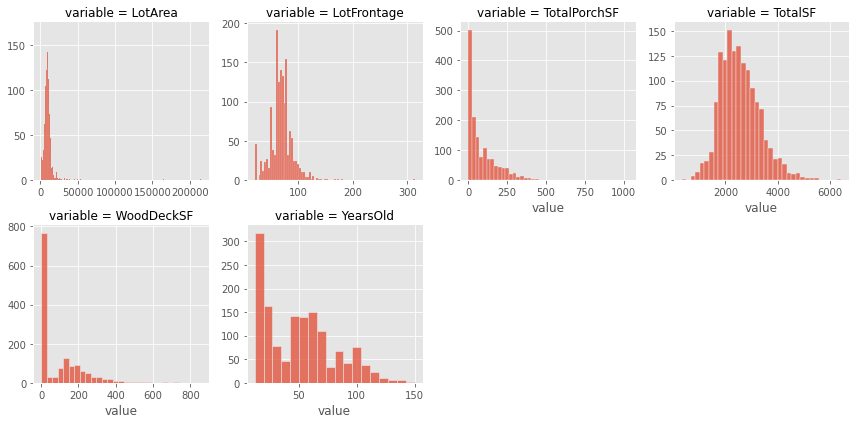

In [13]:
# Grid of distribution plots of all numerical features
f = pd.melt(train, value_vars=sorted(['LotFrontage', 'LotArea', 'WoodDeckSF', 'TotalSF', 'TotalPorchSF', 'YearsOld']))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.histplot, 'value')

## Categorical Features

c:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


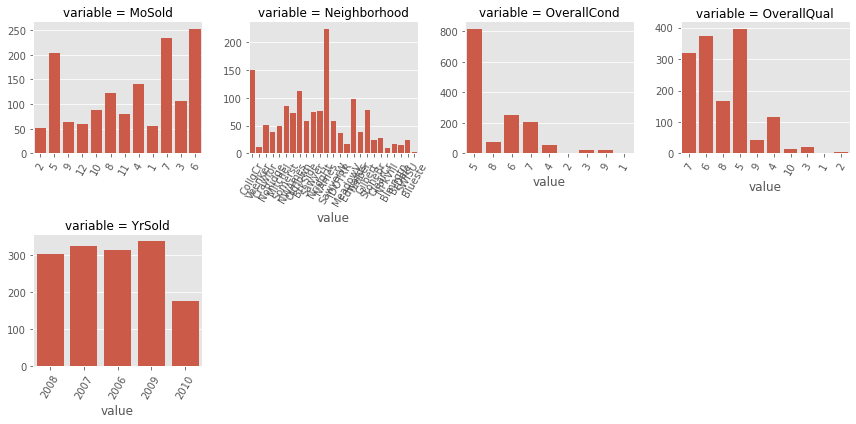

In [14]:
# Count plots of categorical features
f = pd.melt(train, value_vars=sorted(cat_features))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
plt.xticks(rotation='vertical')
g = g.map(sns.countplot, 'value')
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

## Numerical Scatterplots against SalePrice

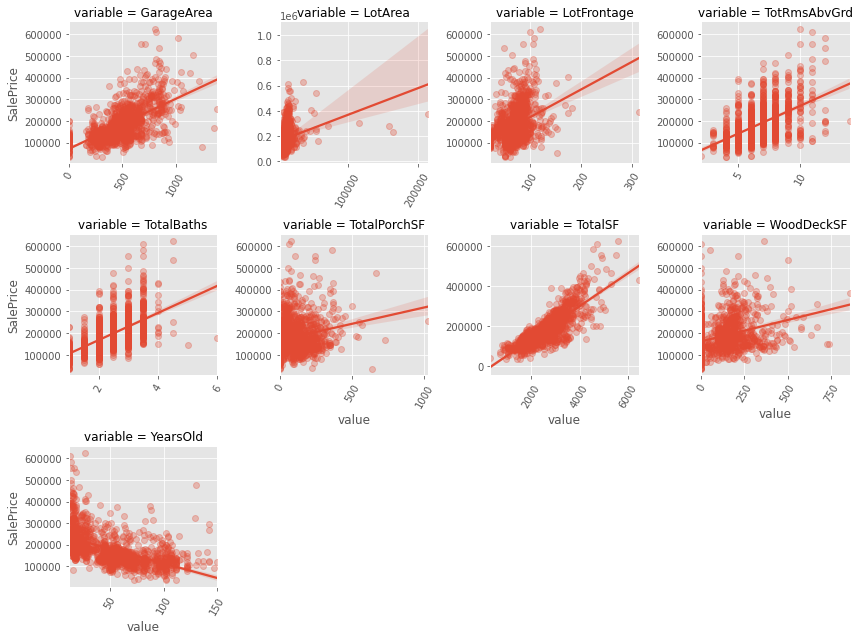

In [15]:
f = pd.melt(train, id_vars=['SalePrice'], value_vars=sorted(num_features))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
plt.xticks(rotation='vertical')
g = g.map(sns.regplot, 'value', 'SalePrice', scatter_kws={'alpha':0.3})
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

## Now, we will evaluate the correlated between numerical features

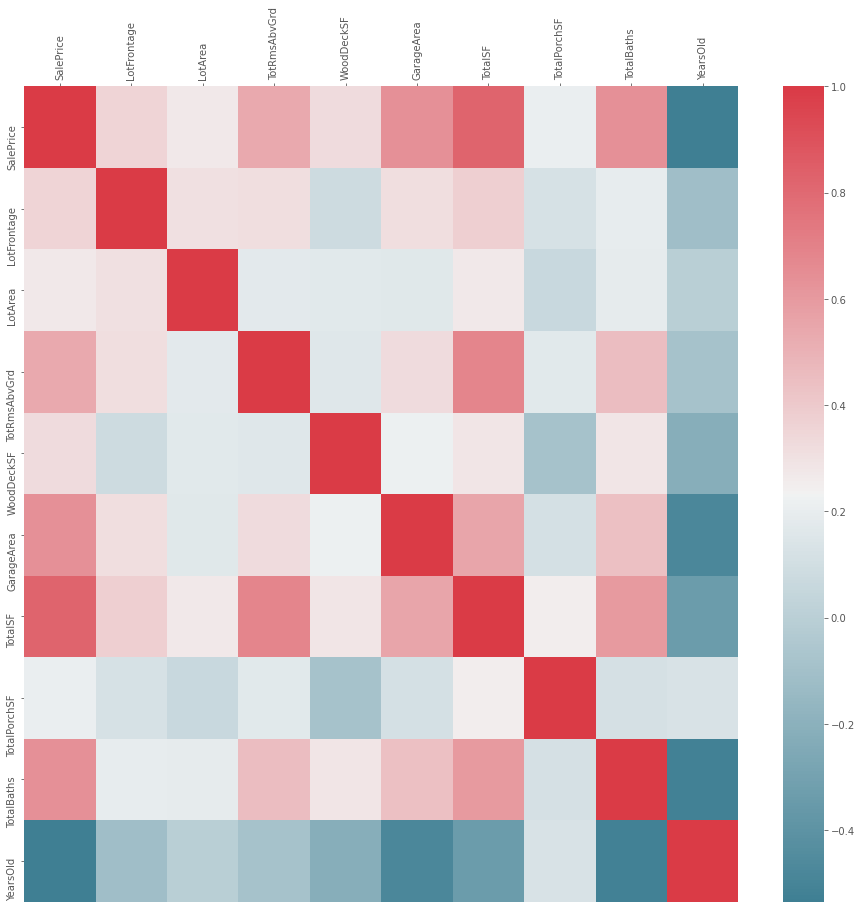

In [16]:
corr = train[['SalePrice'] + num_features].corr()
fig = plt.figure(figsize=(16,15))
ax = fig.add_subplot(111)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, 
           xticklabels=corr.columns.values,
           yticklabels=corr.index.values,
           cmap=cmap)
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

## Correlation with Sale Price

c:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


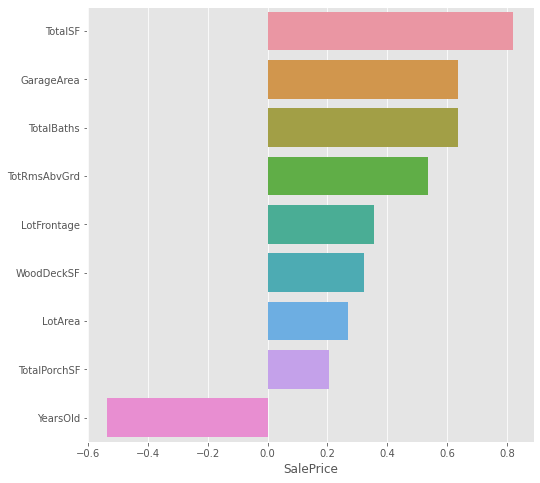

In [17]:
corr = corr.sort_values('SalePrice', ascending=False)
plt.figure(figsize=(8,8))
sns.barplot( corr.SalePrice[1:], corr.index[1:], orient='h')
plt.show()

## Boxplots for categorical features

c:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
c:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


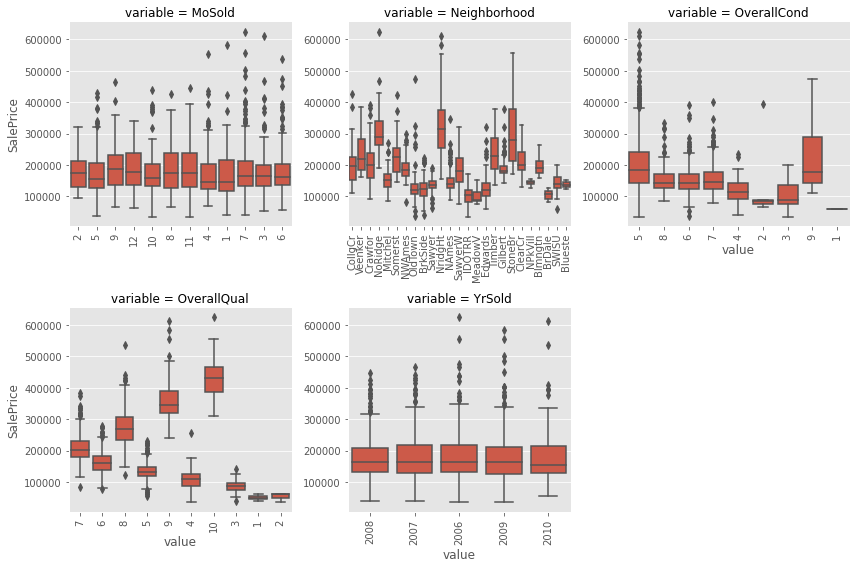

In [299]:
f = pd.melt(train, id_vars=['SalePrice'], value_vars=sorted(cat_features))
g = sns.FacetGrid(f, col='variable', col_wrap=3, sharex=False, sharey=False, size=4)
g = g.map(sns.boxplot, 'value', 'SalePrice')
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

## One Way ANOVA for all categorical variables

In [300]:
# In order for ANOVA to work, we have to take care of missing values first
train[cat_features] = train[cat_features].fillna('NA')

# Onward...
anova = {'feature':[], 'f':[], 'p':[]}
for cat in cat_features:
    group_prices = []
    for group in train[cat].unique():
        group_prices.append(train[train[cat] == group]['SalePrice'].values)
    f, p = scipy.stats.f_oneway(*group_prices)
    anova['feature'].append(cat)
    anova['f'].append(f)
    anova['p'].append(p)
anova = pd.DataFrame(anova)
anova = anova[['feature','f','p']]
anova.sort_values('p', inplace=True)

anova['significant'] = anova['p'] < .01

display(anova)

,feature,f,p,significant
1,OverallQual,374.109132,0.000000e+00,True
0,Neighborhood,74.023903,1.633204e-230,True
2,OverallCond,28.479122,1.869669e-41,True
4,MoSold,0.984846,4.579143e-01,False
3,YrSold,0.319918,8.647617e-01,False


## Data Preprocessing and Regression

In [301]:
## Let's log transform any features that have a skew of more than .5

skewed_num_features = []

for feature in num_features:
    if feature != 'TotRmsAbvGrd':
        if train[feature].skew() > .5:
            skewed_num_features.append(feature)
            print(feature, 'Skew Value:', train[feature].skew())

print('Skewed Features:',skewed_num_features)
print('Number of Skewed Features:',len(skewed_num_features))

for feature in skewed_num_features:
    train[feature] = np.log1p(train[feature])

## Also Transform Sale Price
train['SalePrice'] = np.log1p(train['SalePrice'])

LotFrontage Skew Value: 1.5384776962269666
LotArea Skew Value: 12.587561473397649
WoodDeckSF Skew Value: 1.5512706094546915
TotalSF Skew Value: 0.6520457594430947
TotalPorchSF Skew Value: 2.0094980803022904
YearsOld Skew Value: 0.6100865132247293
Skewed Features: ['LotFrontage', 'LotArea', 'WoodDeckSF', 'TotalSF', 'TotalPorchSF', 'YearsOld']
Number of Skewed Features: 6


## Dummy Variables

In [302]:
train.drop(columns=['YrSold', 'MoSold', 'TotRmsAbvGrd'], axis=1, inplace=True)
num_features, cat_features = get_feature_groups()

# before we continue, let's drop some cols
y = train['SalePrice']
train.drop('SalePrice', axis=1, inplace=True)

In [303]:
# ... and go
model_data = pd.get_dummies(train).copy()

display(model_data)
display(y)

,LotFrontage,LotArea,WoodDeckSF,GarageArea,TotalSF,TotalPorchSF,TotalBaths,YearsOld,Neighborhood_Blmngtn,Neighborhood_Blueste,...,OverallQual_9,OverallCond_1,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9
Id,,,,,,,,,,,,,,,,,,,,,
1,4.189655,9.042040,0.000000,548,7.850493,4.127134,3.5,2.995732,0,0,...,0,0,0,0,0,1,0,0,0,0
2,4.394449,9.169623,5.700444,460,7.833996,0.000000,2.5,3.850148,0,0,...,0,0,0,0,0,0,0,0,1,0
3,4.234107,9.328212,0.000000,608,7.903596,3.761200,3.5,3.091042,0,0,...,0,0,0,0,0,1,0,0,0,0
4,4.110874,9.164401,0.000000,642,7.813592,5.730100,2.0,4.682131,0,0,...,0,0,0,0,0,1,0,0,0,0
5,4.442651,9.565284,5.262690,836,8.114923,4.442651,3.5,3.135494,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,4.143135,8.976894,0.000000,460,7.863651,3.713572,2.5,3.178054,0,0,...,0,0,0,0,0,1,0,0,0,0
1457,4.454347,9.486152,5.857933,500,8.193124,0.000000,3.0,3.806662,0,0,...,0,0,0,0,0,0,1,0,0,0
1458,4.204693,9.109746,0.000000,252,8.158516,4.110874,2.0,4.406719,0,0,...,0,0,0,0,0,0,0,0,0,1


Id
1       12.247699
2       12.109016
3       12.317171
4       11.849405
5       12.429220
          ...    
1456    12.072547
1457    12.254868
1458    12.493133
1459    11.864469
1460    11.901590
Name: SalePrice, Length: 1456, dtype: float64

## Standardization

In [304]:
# Split data intro train and validation sets
X_train, X_test, y_train, y_test = train_test_split(model_data.copy(), y, test_size=0.3, random_state=42)
print('Shapes')
print('X_train:', X_train.shape)
print('X_val:', X_test.shape)
print('y_train:', y_train.shape)
print('y_val:', y_test.shape)

Shapes
X_train: (1019, 52)
X_val: (437, 52)
y_train: (1019,)
y_val: (437,)


In [305]:
stdscl = StandardScaler()

X_train.loc[:,num_features] = stdscl.fit_transform(X_train[num_features])
X_test.loc[:,num_features] = stdscl.transform(X_test[num_features])

## MLR WITH ALL OUR VARIABLES

In [306]:
def model_evaluation_plots(model, X_train, y_train, X_test, y_test):
    y_train_preds = model.predict(X_train)
    y_test_preds = model.predict(X_test)
    
    plt.figure(figsize=(12,6))
    # Residuals
    plt.subplot(121)
    plt.scatter(y_train_preds, y_train_preds - y_train, c='blue', marker='o', label='Training data')
    plt.scatter(y_test_preds, y_test_preds - y_test, c='orange', marker='s', label='Validation data')
    plt.title('Residuals')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=y_train.min(), xmax=y_train.max(), color='red')

    # Predictions
    plt.subplot(122)
    plt.scatter(y_train_preds, y_train, c='blue', marker='o', label='Training data')
    plt.scatter(y_test_preds, y_test, c='orange', marker='s', label='Validation data')
    plt.title('Predictions')
    plt.xlabel('Predicted values')
    plt.ylabel('Real values')
    plt.legend(loc='upper left')
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c='red')
    plt.tight_layout()
    plt.show()

import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))


explained_variance:  0.9095
mean_squared_log_error:  0.0164
r2:  0.909
MAE:  15314.2023
MSE:  456698155.0192
RMSE:  21370.4973
Mean Absolute Error: 15314.202349189034
Mean Squared Error: 456698155.01923865
Root Mean Squared Error: 21370.49730397584


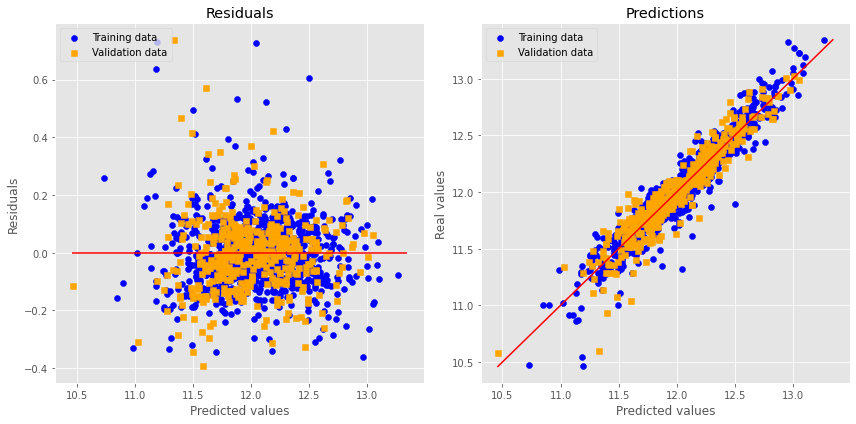

In [307]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

df = pd.DataFrame({'Actual': np.expm1(y_test), 'Predicted': np.expm1(y_pred)})
df

regression_results(np.expm1(y_test), np.expm1(y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(np.expm1(y_test), np.expm1(y_pred)))  
print('Mean Squared Error:', metrics.mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.expm1(y_test), np.expm1(y_pred))))

model_evaluation_plots(lr, X_train, y_train, X_test, y_test)


In [308]:
from statsmodels.api import OLS
from statsmodels.api import graphics
stats_model = OLS(y_train,X_train).fit()
stats_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     212.3
Date:                Thu, 28 Jul 2022   Prob (F-statistic):               0.00
Time:                        12:11:48   Log-Likelihood:                 732.63
No. Observations:                1019   AIC:                            -1367.
Df Residuals:                     970   BIC:                            -1126.
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
LotFrontage              0.0007      0.006      0.122      0.903      -0.011       0.012
LotArea                  0.0575      0.006      8.991      0.000       0.045       0.070
WoodDeckSF               0.0094      0.004      2.221      0.027       0.001       0.018
GarageArea               0.0416      0.005      7.779      0.000       0.031       0.052
TotalSF                  0.1208      0.007     17.927      0.000       0.108       0.134
TotalPorchSF             0.0165      0.004      3.875      0.000       0.008       0.025
TotalBaths               0.0532      0.006      9.660      0.000       0.042       0.064
YearsOld                -0.0974      0.010     -9.614      0.000      -0.117      -0.077
Neighborhood_Blmngtn     1.9433      0.035     55.257      0.000       1.874       2.012
Neighborhood_Blueste     1.9833      0.119     16.639      0.000       1.749       2.217
Neighborhood_BrDale      1.9228      0.044     44.018      0.000       1.837       2.008
Neighborhood_BrkSide     1.9465      0.023     85.246      0.000       1.902       1.991
Neighborhood_ClearCr     1.9423      0.030     64.753      0.000       1.883       2.001
Neighborhood_CollgCr     1.8809      0.016    118.261      0.000       1.850       1.912
Neighborhood_Crawfor     2.0665      0.023     91.559      0.000       2.022       2.111
Neighborhood_Edwards     1.8440      0.017    106.709      0.000       1.810       1.878
Neighborhood_Gilbert     1.8800      0.021     90.873      0.000       1.839       1.921
Neighborhood_IDOTRR      1.7453      0.027     64.386      0.000       1.692       1.799
Neighborhood_MeadowV     1.8414      0.046     39.816      0.000       1.751       1.932
Neighborhood_Mitchel     1.8390      0.022     84.020      0.000       1.796       1.882
Neighborhood_NAmes       1.8943      0.014    138.410      0.000       1.867       1.921
Neighborhood_NPkVill     1.9448      0.051     38.343      0.000       1.845       2.044
Neighborhood_NWAmes      1.8522      0.019     98.438      0.000       1.815       1.889
Neighborhood_NoRidge     2.0108      0.025     79.557      0.000       1.961       2.060
Neighborhood_NridgHt     1.9457      0.022     89.016      0.000       1.903       1.989
Neighborhood_OldTown     1.8132      0.019     95.312      0.000       1.776       1.851
Neighborhood_SWISU       1.9037      0.038     49.613      0.000       1.828       1.979
Neighborhood_Sawyer      1.8826      0.019     96.571      0.000       1.844       1.921
Neighborhood_SawyerW     1.8690      0.021     90.713      0.000       1.829       1.909
Neighborhood_Somerst     1.9179      0.020     94.582      0.000       1.878       1.958
Neighborhood_StoneBr     2.0360      0.029     69.037      0.000       1.978       2.094
Neighborhood_Timber      1.8992      0.027     71.258    

In [309]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))]

display(vif_data.head(9))

c:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,LotFrontage,2.294590
1,LotArea,2.854278
2,WoodDeckSF,1.244522
3,GarageArea,1.997873
4,TotalSF,3.169309
5,TotalPorchSF,1.272145
6,TotalBaths,2.113038
7,YearsOld,7.157472
8,Neighborhood_Blmngtn,inf


## Ridge

Ridge(alpha=0.7)


,Actual,Predicted
Id,,
498,184000.0,179832.594977
1265,181000.0,178729.199905
412,145000.0,149163.755828
1049,115000.0,108503.326507
1036,84000.0,61134.704871
...,...,...
324,126175.0,115104.298624
1290,281000.0,271381.949632
727,222000.0,300859.794566


Mean Absolute Error: 15230.924073462838
Mean Squared Error: 450226147.23018324
Root Mean Squared Error: 21218.533107408326


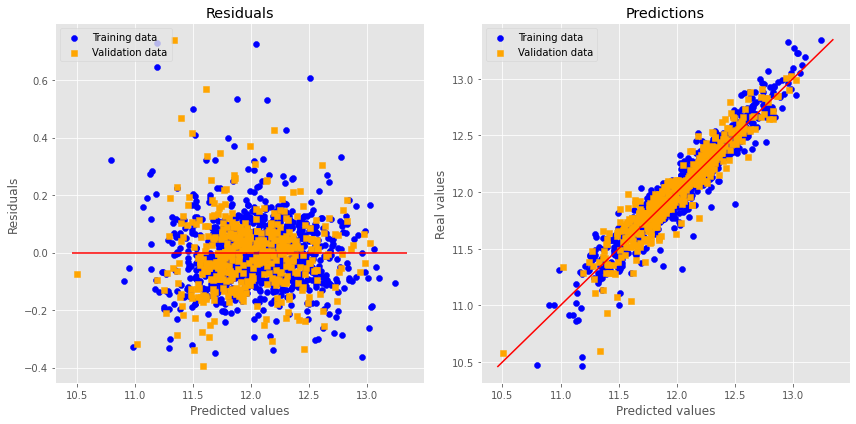

explained_variance:  0.9109
mean_squared_log_error:  0.0163
r2:  0.9103
MAE:  15230.9241
MSE:  450226147.2302
RMSE:  21218.5331


In [310]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# We're using GridSearch here to find the optimal alpha value
# Get the ballpark
param_grid = {'alpha': [0.01, 0.1, 1., 5., 10., 25., 50., 100.]}
ridge = GridSearchCV(Ridge(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')
ridge.fit(X_train, y_train)
alpha = ridge.best_params_['alpha']

# Hone in
param_grid = {'alpha': [x/100. * alpha for x in range(50, 150, 5)]}
ridge = GridSearchCV(Ridge(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')
ridge.fit(X_train, y_train)
alpha = ridge.best_params_['alpha']
ridge = ridge.best_estimator_

print(ridge)

y_pred = ridge.predict(X_test)

df = pd.DataFrame({'Actual': np.expm1(y_test), 'Predicted': np.expm1(y_pred)})
display(df)

print('Mean Absolute Error:', metrics.mean_absolute_error(np.expm1(y_test), np.expm1(y_pred)))  
print('Mean Squared Error:', metrics.mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.expm1(y_test), np.expm1(y_pred))))

model_evaluation_plots(ridge, X_train, y_train, X_test, y_test)

regression_results(np.expm1(y_test), np.expm1(y_pred))


Ridge dropped 0 of 52 features.


c:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


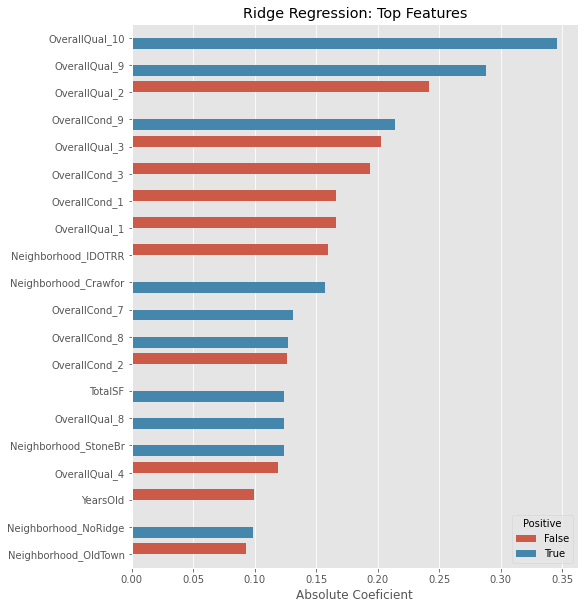

In [311]:
# Let's take a look at what the Ridge regression made of our features.
coefs = pd.DataFrame({'coefs':ridge.coef_,'Positive':ridge.coef_ > 0}, index=X_train.columns)
coefs['coefs_abs'] = np.abs(coefs.coefs)
print('Ridge dropped {} of {} features.'.format(
    sum(coefs.coefs == 0), coefs.shape[0]))

top_coefs = coefs.sort_values('coefs_abs', ascending=False).head(20)
plt.figure(figsize=(8,10))
sns.barplot( top_coefs.coefs_abs, top_coefs.index, orient='h', hue=top_coefs.Positive)
plt.title('Ridge Regression: Top Features')
plt.xlabel('Absolute Coeficient')
plt.show()

## LASSO

Lasso(alpha=5e-05, max_iter=50000)


,Actual,Predicted
Id,,
498,184000.0,180205.254888
1265,181000.0,178529.083839
412,145000.0,149092.895795
1049,115000.0,108963.280138
1036,84000.0,61424.684042
...,...,...
324,126175.0,113959.698060
1290,281000.0,270166.899862
727,222000.0,300839.934082


Mean Absolute Error: 15280.099974153403
Mean Squared Error: 453984037.2862264
Root Mean Squared Error: 21306.90116573094


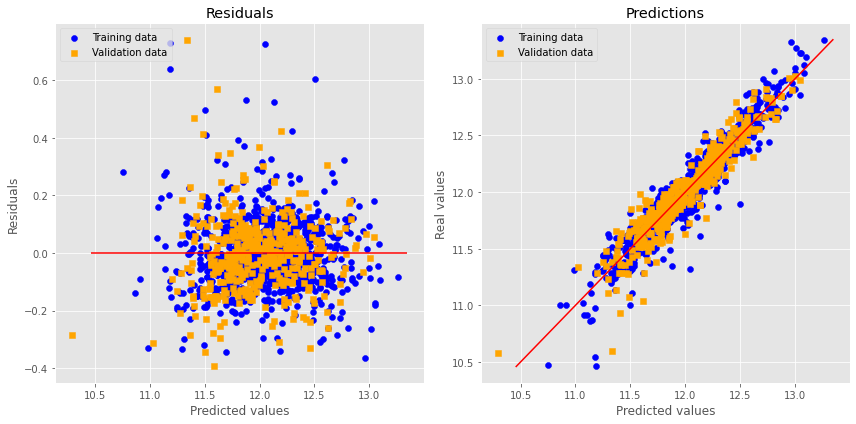

explained_variance:  0.9101
mean_squared_log_error:  0.0165
r2:  0.9095
MAE:  15280.1
MSE:  453984037.2862
RMSE:  21306.9012


In [312]:
from sklearn.linear_model import Lasso

# We're using GridSearch here to find the optimal alpha value
# Get the ballpark
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1., 5., 10., 25.], 'max_iter': [50000]}
lasso = GridSearchCV(Lasso(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')
lasso.fit(X_train, y_train)
alpha = lasso.best_params_['alpha']

# Hone in
param_grid = {'alpha': [x/100. * alpha for x in range(50, 150, 5)], 'max_iter': [50000]}
lasso = GridSearchCV(Lasso(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')
lasso.fit(X_train, y_train)
alpha = lasso.best_params_['alpha']
lasso = lasso.best_estimator_

print(lasso)

y_pred = lasso.predict(X_test)

df = pd.DataFrame({'Actual': np.expm1(y_test), 'Predicted': np.expm1(y_pred)})
display(df)

print('Mean Absolute Error:', metrics.mean_absolute_error(np.expm1(y_test), np.expm1(y_pred)))  
print('Mean Squared Error:', metrics.mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.expm1(y_test), np.expm1(y_pred))))

model_evaluation_plots(lasso, X_train, y_train, X_test, y_test)

regression_results(np.expm1(y_test), np.expm1(y_pred))


LASSO dropped 3 of 52 features.


c:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


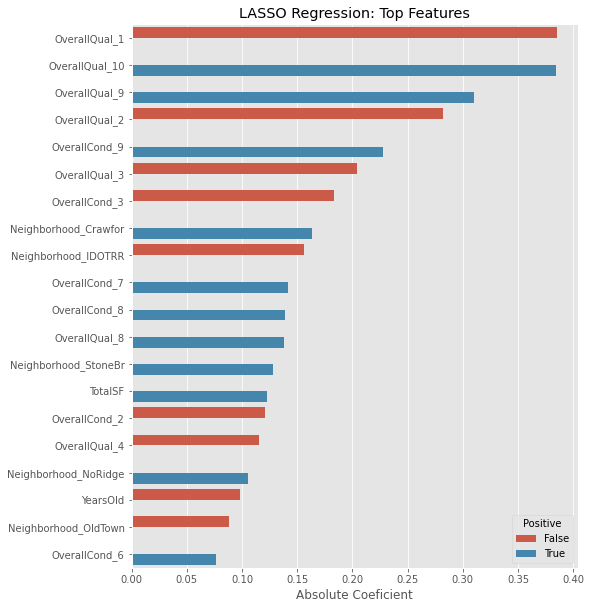

In [313]:
# Let's take a look at what the LASSO regression made of our features.
coefs = pd.DataFrame({'coefs':lasso.coef_,'Positive':lasso.coef_ > 0}, index=X_train.columns)
coefs['coefs_abs'] = np.abs(coefs.coefs)
print('LASSO dropped {} of {} features.'.format(
    sum(coefs.coefs == 0), coefs.shape[0]))

top_coefs = coefs.sort_values('coefs_abs', ascending=False).head(20)
plt.figure(figsize=(8,10))
sns.barplot( top_coefs.coefs_abs, top_coefs.index, orient='h', hue=top_coefs.Positive)
plt.title('LASSO Regression: Top Features')
plt.xlabel('Absolute Coeficient')
plt.show()

In [314]:
display(coefs.loc[coefs['coefs_abs'] == 0])

,coefs,Positive,coefs_abs
LotFrontage,0.0,False,0.0
Neighborhood_SWISU,0.0,False,0.0
OverallCond_5,-0.0,False,0.0
